In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import math
import os
from scipy import ndimage
import random

In [ ]:
SCRIPT_DIR = os.getcwd()
datasets_path = os.path.join(SCRIPT_DIR,os.pardir, "an2dl2526c2", "preprocessing_results", "train_noshreks", "train_tissue")
mask_path = os.path.join(SCRIPT_DIR,os.pardir, "an2dl2526c2", "preprocessing_results", "train_nogoo", "cleaned_masks")
DATASET_PATH = os.path.join(datasets_path)
MASK_PATH = os.path.join(mask_path)



In [ ]:
import numpy as np
from PIL import Image
from scipy import ndimage


def extract_smart_patches(
    img_path,
    mask_path,
    patch_size=224,
    stride=224,
    threshold=0.01,
    dilate_iterations=15,
    enforce_blob_overlap=True,

    # --- patch count controls ---
    pad_fraction=0.0,          # 0.0 = no bbox padding (recommended to reduce count)
    max_patches_per_blob=None,    # cap kept patches per blob
    iou_thresh=0.5,           # NMS: reject if overlaps too much with already kept patches
    score_mode="mask_ratio", # "tumor_pixels" or "mask_ratio"
):
    """
    Extract patches over tumor blobs, with multi-patch coverage for big blobs BUT controlled patch count.

    - Dilate + label to form blobs
    - Tile candidate patches over each blob bbox (optionally padded)
    - Filter by tumor ratio + tissue ratio
    - Optional: ensure each patch overlaps its specific blob label
    - Reduce redundancy via NMS (IoU) and cap max_patches_per_blob
    """

    # --- Load images ---
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        if img_path.endswith(".png"):
            img = Image.open(img_path.replace(".png", ".jpg")).convert("RGB")
        else:
            raise

    mask = Image.open(mask_path).convert("L")

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Normalize mask to 0..255 for consistent thresholding
    mask_check = (mask_arr * 255) if mask_arr.max() <= 1 else mask_arr

    h, w = img_arr.shape[:2]

    if isinstance(patch_size, int):
        ph, pw = patch_size, patch_size
    else:
        ph, pw = patch_size

    if isinstance(stride, int):
        sh, sw = stride, stride
    else:
        sh, sw = stride

    # --- helpers ---
    def clamp_start(v, max_v, p):
        return max(0, min(int(v), int(max_v - p)))

    def make_starts(min_v, max_v, p, s, limit):
        """Cover [min_v, max_v) with windows of size p using stride s, include endpoint."""
        min_v = int(min_v)
        max_v = int(max_v)
        if max_v - min_v <= p:
            mid = (min_v + max_v) // 2 - p // 2
            return [clamp_start(mid, limit, p)]
        starts = list(range(min_v, max_v - p + 1, s))
        end = max_v - p
        if not starts:
            starts = [end]
        elif starts[-1] != end:
            starts.append(end)
        return [clamp_start(v, limit, p) for v in starts]

    def iou_xywh(a, b):
        """IoU for boxes in (x, y, w, h)."""
        ax, ay, aw, ah = a
        bx, by, bw, bh = b
        ax2, ay2 = ax + aw, ay + ah
        bx2, by2 = bx + bw, by + bh

        ix1, iy1 = max(ax, bx), max(ay, by)
        ix2, iy2 = min(ax2, bx2), min(ay2, by2)
        iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
        inter = iw * ih
        if inter == 0:
            return 0.0
        union = aw * ah + bw * bh - inter
        return inter / union

    # --- grouping: dilate + label ---
    dilated_mask = ndimage.binary_dilation(mask_check > 128, iterations=dilate_iterations)
    labeled_mask, num_features = ndimage.label(dilated_mask)
    objects = ndimage.find_objects(labeled_mask)

    print(f"Found {num_features} clustered tumor regions (after grouping).")

    kept_patches = []
    kept_coords = []
    kept_xy = set()  # avoid duplicates across blobs

    # --- per blob: make candidates, score, NMS, cap ---
    for i, slice_obj in enumerate(objects):
        if slice_obj is None:
            continue

        label_id = i + 1
        y_slice, x_slice = slice_obj
        y_min, y_max = y_slice.start, y_slice.stop
        x_min, x_max = x_slice.start, x_slice.stop

        # bbox padding control (pad_fraction=0.0 keeps tight bbox)
        pad_y = int(ph * pad_fraction)
        pad_x = int(pw * pad_fraction)

        y0 = max(0, y_min - pad_y)
        y1 = min(h, y_max + pad_y)
        x0 = max(0, x_min - pad_x)
        x1 = min(w, x_max + pad_x)

        y_starts = make_starts(y0, y1, ph, sh, h)
        x_starts = make_starts(x0, x1, pw, sw, w)

        candidates = []
        for y in y_starts:
            for x in x_starts:
                # ensure patch is for this blob (optional)
                if enforce_blob_overlap:
                    lbl_patch = labeled_mask[y:y + ph, x:x + pw]
                    if not np.any(lbl_patch == label_id):
                        continue

                img_patch = img_arr[y:y + ph, x:x + pw]
                mask_patch = mask_check[y:y + ph, x:x + pw]

                # tissue ratio (avoid mostly background)
                img_gray = np.mean(img_patch, axis=2)
                tissue_ratio = np.sum(img_gray < 235) / (ph * pw)
                if tissue_ratio <= 0.15:
                    continue

                # tumor ratio threshold
                tumor_pixels = int(np.sum(mask_patch > 128))
                mask_ratio = tumor_pixels / (ph * pw)
                if mask_ratio < threshold:
                    continue

                # score for ranking (higher = keep first)
                if score_mode == "mask_ratio":
                    score = float(mask_ratio)
                else:
                    score = float(tumor_pixels)  # default: prioritize most tumor content

                candidates.append((score, x, y))

        if not candidates:
            continue

        # sort best-first
        candidates.sort(key=lambda t: t[0], reverse=True)

        # greedy NMS within this blob + cap
        selected_boxes = []
        selected = 0

        for score, x, y in candidates:
            if (x, y) in kept_xy:
                continue

            box = (x, y, pw, ph)

            if iou_thresh is not None and selected_boxes:
                too_much_overlap = any(iou_xywh(box, b) >= iou_thresh for b in selected_boxes)
                if too_much_overlap:
                    continue

            # accept
            kept_patches.append(img_arr[y:y + ph, x:x + pw])
            kept_coords.append((x, y))
            kept_xy.add((x, y))
            selected_boxes.append(box)
            selected += 1

            if max_patches_per_blob is not None and selected >= max_patches_per_blob:
                break

    return kept_patches, kept_coords, img_arr, mask_arr


In [43]:
# --- Execution & Visualization ---
idx = 182
idx = random.randint(0,671)

IMG_NAME = f"img_{idx:04d}.png"
MASK_NAME = IMG_NAME.replace("img", "mask")
# Usage Example
img_path = os.path.join(DATASET_PATH, IMG_NAME)
mask_path = os.path.join(MASK_PATH, MASK_NAME)

# Run the smart extraction
valid_patches, valid_coords, full_img_arr, full_mask_arr = extract_smart_patches(
    img_path, 
    mask_path, 
    patch_size=224,   # Context window size
    stride=244,       # Overlap for large regions
    threshold=0.01,   # Lower threshold is okay because we target specific objects
    dilate_iterations=15,
    enforce_blob_overlap=True, 
    # --- patch count controls ---
    pad_fraction=0.0,          # 0.0 = no bbox padding (recommended to reduce count)
    max_patches_per_blob=None,    # cap kept patches per blob
    iou_thresh=0.5,           # NMS: reject if overlaps too much with already kept patches
    score_mode="mask_ratio", # "tumor_pixels" or "mask_ratio"
)
print(f"Smartly extracted {len(valid_patches)} patches focused on ROIs.")

Found 8 clustered tumor regions (after grouping).
Smartly extracted 8 patches focused on ROIs.


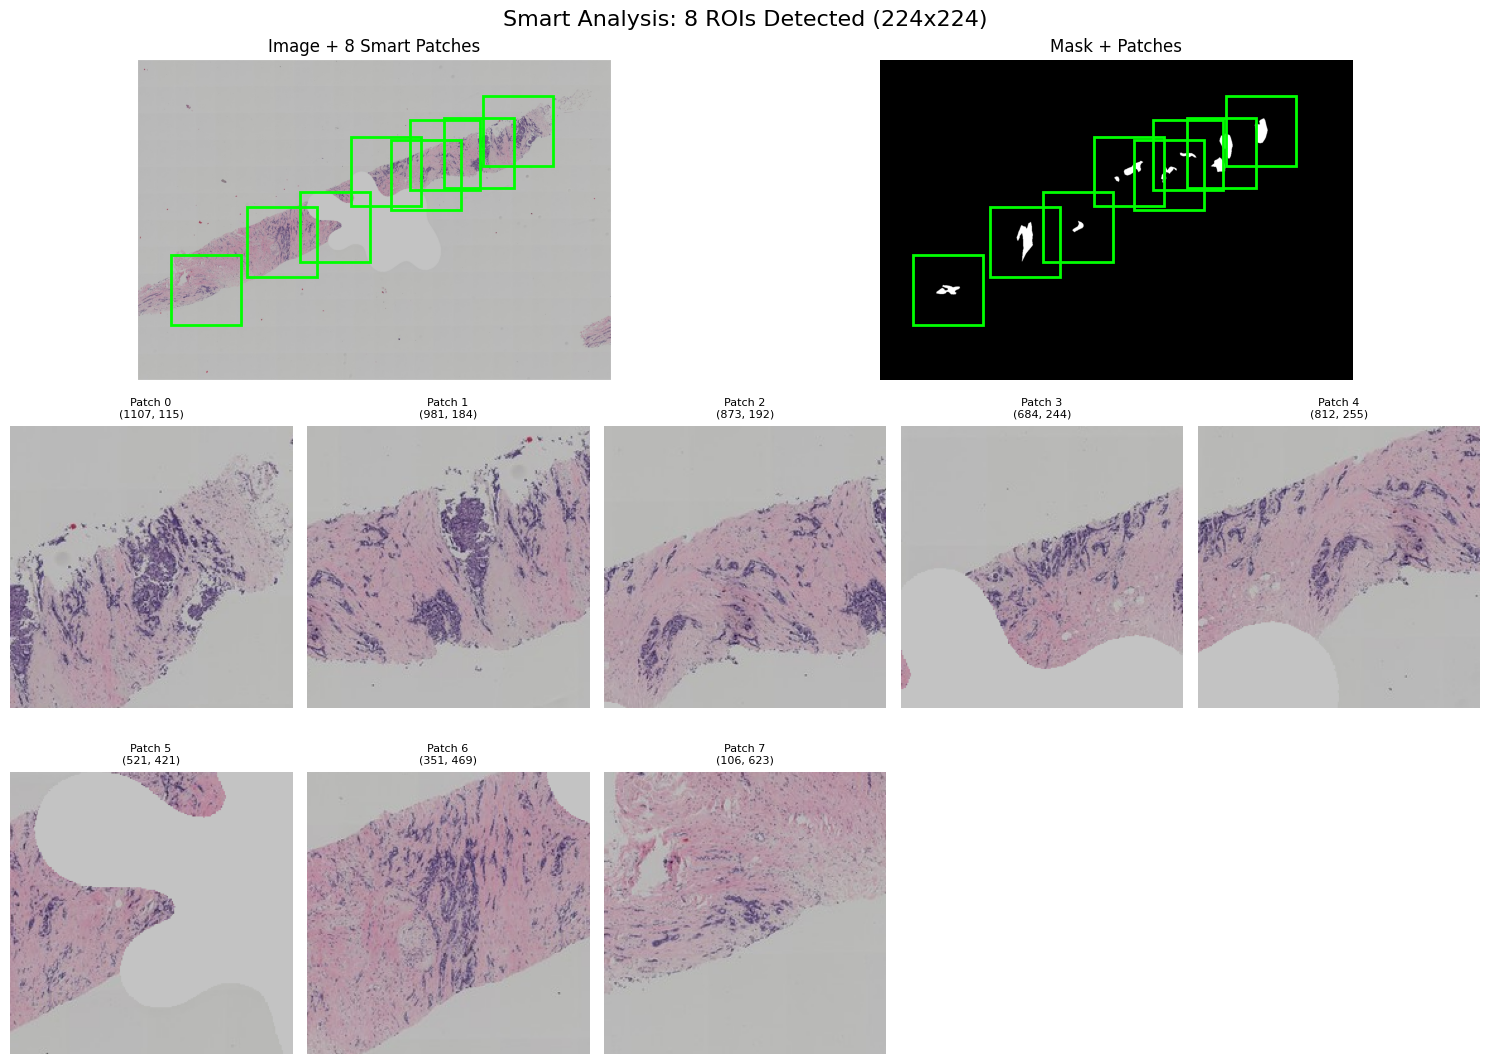

In [44]:
# Visualize
if len(valid_patches) > 0:
    n_patches = len(valid_patches)
    patch_cols = 5
    patch_rows = math.ceil(n_patches / patch_cols)
    total_rows = 1 + patch_rows 
    
    # Get actual patch dimensions for accurate plotting
    actual_h, actual_w = valid_patches[0].shape[:2]

    # Dynamic figure height
    fig = plt.figure(figsize=(15, 5 + 3 * patch_rows))
    gs = gridspec.GridSpec(total_rows, 10, figure=fig)
    fig.suptitle(f"Smart Analysis: {n_patches} ROIs Detected ({actual_h}x{actual_w})", fontsize=16)
    
    # --- 1. Image Overlay (Top Left) ---
    ax1 = fig.add_subplot(gs[0, 0:5])
    ax1.imshow(full_img_arr)
    ax1.set_title(f"Image + {n_patches} Smart Patches")
    ax1.axis('off')
    for (x, y) in valid_coords:
        # Draw rectangle matching patch size
        rect = mpatches.Rectangle((x, y), actual_w, actual_h, linewidth=2, edgecolor='lime', facecolor='none')
        ax1.add_patch(rect)

    # --- 2. Mask Overlay (Top Right) ---
    ax2 = fig.add_subplot(gs[0, 5:10])
    ax2.imshow(full_mask_arr, cmap='gray')
    ax2.set_title("Mask + Patches")
    ax2.axis('off')
    for (x, y) in valid_coords:
        rect = mpatches.Rectangle((x, y), actual_w, actual_h, linewidth=2, edgecolor='lime', facecolor='none')
        ax2.add_patch(rect)

    # --- 3. Patch Grid (Bottom Rows) ---
    for i in range(n_patches):
        r = 1 + (i // patch_cols)
        c_start = (i % patch_cols) * 2
        
        ax_patch = fig.add_subplot(gs[r, c_start:c_start+2])
        ax_patch.imshow(valid_patches[i])
        ax_patch.set_title(f"Patch {i}\n{valid_coords[i]}", fontsize=8)
        ax_patch.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No valid patches found.")